# **Sprint 9 Showz analysis**

## Paso 1. Acceda los datos y prepáralos para el análisis

Almacena los datos de visitas, pedidos y gastos en variables.  Optimiza los datos para el análisis. Asegúrate de que cada columna contenga el tipo de datos correcto. 




In [206]:
# cargar librerías
import pandas as pd 
import numpy as np
import re 
import seaborn as sns
import matplotlib.pyplot as plt


In [207]:
# importar datos
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log_us.csv')
print(visits.head())
print('-------')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log_us.csv')
print(orders.head())
print('-------')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_us.csv')
print(costs.head())
print('-------')

    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  
-------
                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450
-------
   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2    

### Examinar visits

In [208]:
# Examine visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [209]:
visits['Device'].value_counts()

Device
desktop    262567
touch       96833
Name: count, dtype: int64

In [210]:
visits['Source Id'].value_counts()

Source Id
4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: count, dtype: int64

### Limpiar visits
1. Columnas a minúsculas
2. End Ts y Start Ts a formato fecha

In [211]:
# Función para limpiar columnas
def clean_col_names(df):
    df = df.copy()
    df.columns = [
        re.sub(r'\W+', '_', col).strip('_').lower()
        for col in df.columns
    ]
    return df


In [212]:
# Limpiar visits.columns
visits = clean_col_names(visits)
visits

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [213]:
# Cambiar end_ts y start_ts a formato fecha
visits.end_ts = pd.to_datetime(visits['end_ts'])
visits.start_ts = pd.to_datetime(visits['start_ts'])
print(visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None


In [214]:
visits.sample(10)

,device,end_ts,source_id,start_ts,uid
313686,desktop,2017-08-22 23:35:00,4,2017-08-22 23:30:00,2921805129614318989
332325,touch,2017-07-30 22:13:00,5,2017-07-30 22:07:00,10781872231895642130
86610,desktop,2017-12-13 13:16:00,2,2017-12-13 12:15:00,3501596628378158474
272875,desktop,2018-02-12 11:23:00,3,2018-02-12 10:48:00,11969456848149105508
33994,touch,2018-05-03 07:20:00,4,2018-05-03 07:17:00,2296098935647975047
134918,desktop,2018-02-06 23:06:00,3,2018-02-06 22:54:00,7715547010280858279
287218,desktop,2018-02-07 21:08:00,4,2018-02-07 21:08:00,9753493906481431138
159355,desktop,2018-05-24 22:27:00,1,2018-05-24 22:05:00,4613805964480314440
129933,desktop,2017-11-12 00:34:00,2,2017-11-12 00:10:00,642050338707908780
342660,desktop,2017-06-14 12:21:00,3,2017-06-14 12:11:00,255246909617571582


### Examinar orders

In [215]:
# Examine orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [216]:
orders['Revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: Revenue, dtype: float64

In [217]:
orders[orders.Revenue > 1000]

,Buy Ts,Revenue,Uid
23165,2017-12-10 13:04:00,1195.64,5539673724080479777
23244,2017-12-10 20:17:00,2633.28,5539673724080479777
24607,2017-12-17 18:06:00,1109.10,11149926373378902217
36522,2018-02-23 08:54:00,1236.28,11149926373378902217
36682,2018-02-24 09:25:00,1221.37,11149926373378902217
40386,2018-03-18 09:13:00,1073.11,11149926373378902217
47507,2018-05-16 19:53:00,1080.44,11149926373378902217


### Limpiar orders

1. limpiar nombres de columnas
2. 'Buy Ts' a formato fecha

In [218]:
orders = clean_col_names(orders)
orders.buy_ts = pd.to_datetime(orders.buy_ts)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


### Examinar costs

In [219]:
# Examine costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [220]:
costs.sample(5)

,source_id,dt,costs
137,1,2017-10-16,64.75
233,1,2018-01-20,50.77
1012,3,2018-03-14,428.23
1920,9,2017-09-13,8.55
573,2,2017-12-28,195.88


In [221]:
costs.source_id.value_counts()

source_id
5     364
1     363
2     363
3     363
4     363
9     363
10    363
Name: count, dtype: int64

### Limpiar costs

1. 'dt' a formato fecha

In [222]:
costs.dt = pd.to_datetime(costs.dt)
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


## Paso 2. Haz informes y calcula métricas 

### Visitas:
- ¿Cuántas personas lo usan cada día, semana y mes?
- ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).
- ¿Cuál es la duración de cada sesión?
- ¿Con qué frecuencia los usuarios regresan?






In [223]:
# Primero sacaremos de las fechas, el día, la semana, mes y año de la visita
visits['day'] = visits['start_ts'].dt.weekday
visits['week'] = visits['start_ts'].dt.isocalendar().week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.isocalendar().year
visits.sample(10)

,device,end_ts,source_id,start_ts,uid,day,week,month,year
123731,desktop,2018-04-20 17:31:00,5,2018-04-20 17:30:00,16068748186047770670,4,16,4,2018
235005,touch,2018-04-16 22:10:00,4,2018-04-16 21:59:00,7488304750525189309,0,16,4,2018
338531,desktop,2018-01-13 20:46:00,4,2018-01-13 20:32:00,14519058252235106117,5,2,1,2018
319254,desktop,2018-04-19 00:14:00,5,2018-04-19 00:12:00,16955297891884609798,3,16,4,2018
141216,desktop,2017-10-10 10:52:00,3,2017-10-10 10:15:00,12474224607863100452,1,41,10,2017
94219,touch,2018-05-30 20:55:00,4,2018-05-30 20:36:00,10834802116301622719,2,22,5,2018
258005,touch,2017-07-27 00:16:00,5,2017-07-27 00:15:00,7974749052747968593,3,30,7,2017
354280,desktop,2017-08-02 18:12:00,2,2017-08-02 17:29:00,3644482766749211722,2,31,8,2017
66508,desktop,2018-02-08 15:44:00,1,2018-02-08 15:41:00,3904708567745762580,3,6,2,2018
109945,desktop,2017-12-19 22:52:00,5,2017-12-19 22:49:00,8378834409020923479,1,51,12,2017


In [224]:
#Promedio de visitas por día

by_days = visits.groupby(['week', 'day'])['uid'].nunique().reset_index()
print(f'Al día, en promedio, se tienen {by_days.uid.mean():,.2f} visitas.')


Al día, en promedio, se tienen 910.46 visitas.


In [225]:
#Promedio de visitas por semana

by_week = visits.groupby(['year', 'week'])['uid'].nunique().reset_index()
print(f'Por semana, en promedio, tenemos {by_week.uid.mean():,.2f} visitas')

Por semana, en promedio, tenemos 5,716.25 visitas


In [226]:
#Promedio de visitas por semana

by_month = visits.groupby(['year', 'month'])['uid'].nunique().reset_index()
print(f'Por mes, en promedio, tenemos {by_month.uid.mean():,.2f} visitas')

Por mes, en promedio, tenemos 23,228.42 visitas


In [227]:
#Promedio de sesiones por día

sessions_per_day = visits.groupby(['week', 'day'])['uid'].count().reset_index()
print(f'Al día, en promedio, se tienen {sessions_per_day.uid.mean():,.2f} sesiones.')

Al día, en promedio, se tienen 990.08 sesiones.


In [228]:
# Duración de sesiones

visits['session_duration'] = visits.end_ts - visits.start_ts
visits['session_duration_secs'] = visits.session_duration.dt.total_seconds()
avg_session_duration = visits.session_duration_secs.median()
print(f'La media de la duración de la sesión es de {avg_session_duration/60:,.2f} minutos.')

La media de la duración de la sesión es de 5.00 minutos.


In [229]:
# Con qué frecuencia los usuarios regresan? 
comeback_frec = visits.sort_values(by=['uid', 'start_ts'])
visits['time_since_last_visit'] = comeback_frec.groupby(['uid'])['start_ts'].diff()
visits['days_between_visits'] = visits.time_since_last_visit.dt.days
ave_return_time = visits.days_between_visits.median()
print(f'La media del tiempo en que suelen regresar los usuarios es de {ave_return_time:.2f} días.')


La media del tiempo en que suelen regresar los usuarios es de 4.00 días.


En la duración de la sesión y en el tiempo en que suelen regresar los usuarios usamos **la media**, ya que en el promedio los valores atípicos elevaban las cantidades.

### Ventas:
- ¿Cuándo empieza la gente a comprar? (En el análisis de KPI, generalmente nos interesa saber el tiempo que transcurre entre el registro y la conversión, es decir, cuando el usuario se convierte en cliente. Por ejemplo, si el registro y la primera compra ocurren el mismo día, el usuario podría caer en la categoría Conversion 0d. Si la primera compra ocurre al día siguiente, será Conversion 1d. Puedes usar cualquier enfoque que te permita comparar las conversiones de diferentes cohortes para que puedas determinar qué cohorte o canal de marketing es más efectivo.)
- ¿Cuántos pedidos hacen durante un período de tiempo dado?
- ¿Cuál es el tamaño promedio de compra?
- ¿Cuánto dinero traen? (LTV)

In [230]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [231]:
# Fechas de primeras compras
purchases = orders[orders.revenue > 0]
first_purchase = purchases.groupby('uid')['buy_ts'].min().reset_index()
first_purchase.columns = ['uid', 'first_buy_ts']
orders = pd.merge(orders, first_purchase, on='uid')
#orders.sample(5)



In [232]:
# Fechas de registros
registration = orders.groupby('uid')['buy_ts'].min().reset_index()
registration.columns = ['uid', 'registration_ts']
orders = pd.merge(orders, registration, on='uid')
#orders.sample(5)

In [233]:
# Crear cohortes por días transcurridos para comprar despúes del registro
orders['days_to_purchase'] = (orders['first_buy_ts'] - orders['registration_ts']).dt.days
#orders.sample(5)

In [234]:
orders['convertion_delay'] = orders['days_to_purchase'].apply(lambda x: f'{x}d')
#orders.sample(5)

In [235]:
by_cohorts = orders.groupby('convertion_delay')['uid'].nunique()
by_cohorts

convertion_delay
0d      36504
117d        1
12d         1
167d        1
3d          1
65d         1
Name: uid, dtype: int64

Practicamente el 99% de los usuarios compran el mismo día que se registraron. 

Probablemente no sabían de la aplicación, ni les interesaba registrarse hasta que quisieron comprar boletos para un evento al que sí querían asistir.

Como este dato no nos sirve para crear cohortes relevante, agruparemos por dispositivo de usuario

In [236]:
#vamos a agrupar por devices, vamos a ver si hay más de un device por usuario

devices_per_user = visits.groupby('uid')['device'].nunique()
devices_per_user.value_counts()

device
1    220470
2      7699
Name: count, dtype: int64

In [237]:
# añadiremos el source_id a nuestro df donde identificamos los cohortes
by_source = visits.groupby('uid')['source_id'].nunique()
orders = orders.merge(by_source, on='uid')

In [238]:
by_cohorts_source = orders.groupby('source_id')['uid'].nunique()
by_cohorts_source

source_id
1    22431
2     9346
3     3268
4     1079
5      321
6       55
7        9
Name: uid, dtype: int64

In [239]:
source_conversion = (
    orders.groupby('source_id')
    .agg({'uid':'nunique', 'revenue':'sum'})
    .rename(columns={'uid':'unique_users'})
    .sort_values(by='unique_users',ascending=False)
)

source_conversion

,unique_users,revenue
source_id,,
1,22431,98724.56
2,9346,66168.56
3,3268,30065.66
4,1079,18180.00
5,321,35459.94
6,55,2676.61
7,9,781.87


/var/folders/gz/g8hxd6y51310ny_x9n2g6x040000gp/T/ipykernel_10236/1669920340.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/gz/g8hxd6y51310ny_x9n2g6x040000gp/T/ipykernel_10236/1669920340.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


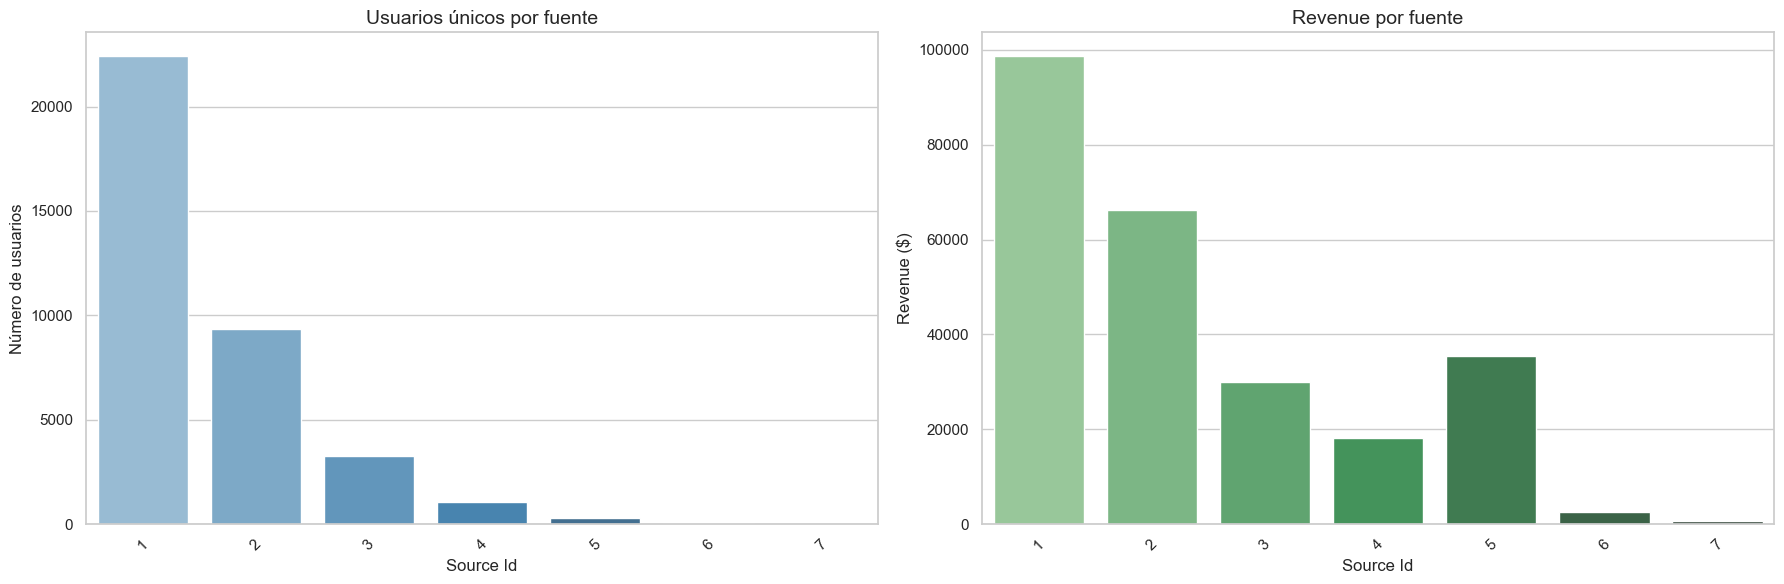

In [240]:
# Crear el canvas de Usuarios únicos y el Revenue por Source Id
sns.set(style="whitegrid")

# Crear figura y subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Primer gráfico: Usuarios únicos
sns.barplot(
    x=source_conversion.index,
    y=source_conversion['unique_users'],
    palette='Blues_d',
    ax=axes[0]
)
axes[0].set_title('Usuarios únicos por fuente', fontsize=14)
axes[0].set_xlabel('Source Id')
axes[0].set_ylabel('Número de usuarios')
axes[0].tick_params(axis='x', rotation=45)

# Segundo gráfico: Revenue
sns.barplot(
    x=source_conversion.index,
    y=source_conversion['revenue'],
    palette='Greens_d',
    ax=axes[1]
)
axes[1].set_title('Revenue por fuente', fontsize=14)
axes[1].set_xlabel('Source Id')
axes[1].set_ylabel('Revenue ($)')
axes[1].tick_params(axis='x', rotation=45)

# Ajustar espacio
plt.tight_layout()
plt.show()


In [241]:
source_conversion['revenue_per_user'] = (source_conversion.revenue / source_conversion.unique_users)
source_conversion

,unique_users,revenue,revenue_per_user
source_id,,,
1,22431,98724.56,4.401255
2,9346,66168.56,7.079880
3,3268,30065.66,9.200018
4,1079,18180.00,16.848934
5,321,35459.94,110.467103
6,55,2676.61,48.665636
7,9,781.87,86.874444


/var/folders/gz/g8hxd6y51310ny_x9n2g6x040000gp/T/ipykernel_10236/3691675975.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


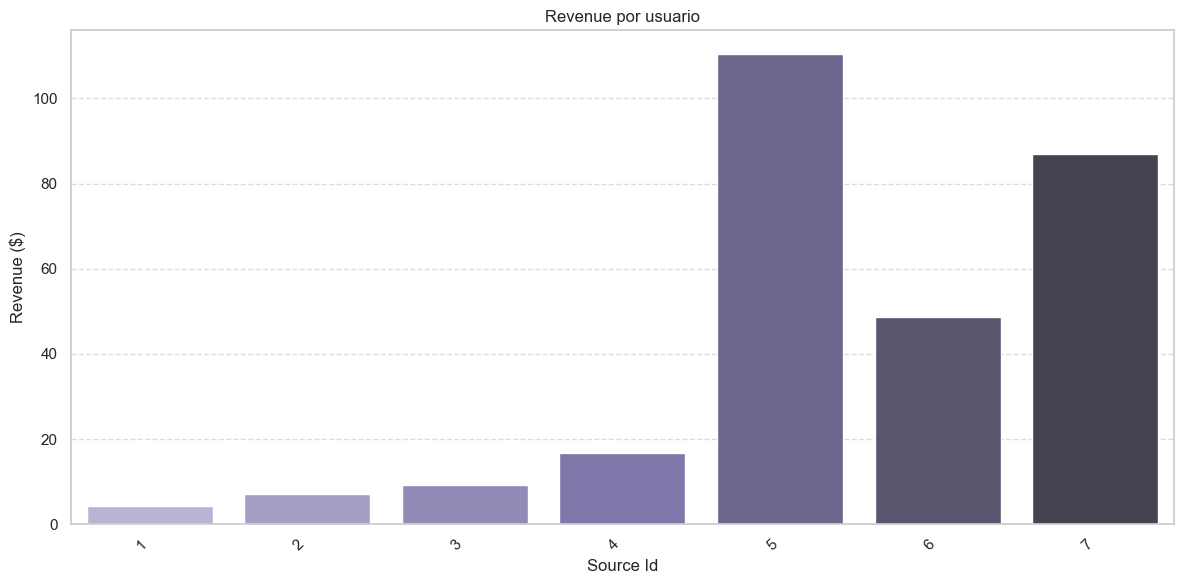

In [242]:
sns.set(style="whitegrid")

plt.figure(figsize=(12,6))

sns.barplot(
    x=source_conversion.index,
    y=source_conversion['revenue_per_user'],
    palette='Purples_d'
)

plt.xticks(rotation=45, ha='right')
plt.title('Revenue por usuario')
plt.xlabel('Source Id')
plt.ylabel('Revenue ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Los canales de Mkt que más usuarios únicos alcanzaron, también fueron los canales que más revenue generaron. Sin embargo el source Id 5 llama la atención porque aunque había pocos usuarios únicos, sus resultados de revenue fueron mucho mayores. Al llevar a cabo la gráfica descubrimos que de hecho los últimos source id's son los que más ingresos generaron por usuario. 

**La recomendación es invertir más en esos sources id's, 5, 6 y 7, para atraer más de esos usuarios que son los que más están dispuestos a gastar en la aplicación.**

In [243]:
# Cuántos pedidos se hacen en un periodo de compra? 
# Agregamos a nuestros datos el mes y el año correspondiente a la compra 

orders['month_buy'] = orders.buy_ts.dt.month
orders['year_buy'] = orders.buy_ts.dt.year
orders.sample(5)

,buy_ts,revenue,uid,first_buy_ts,registration_ts,days_to_purchase,convertion_delay,source_id,month_buy,year_buy
24604,2017-12-17 19:07:00,7.82,11039649446402264600,2017-12-17 19:07:00,2017-12-17 19:07:00,0,0d,2,12,2017
45451,2018-04-25 13:53:00,2.08,4252701676662428304,2018-04-09 11:05:00,2018-04-09 11:05:00,0,0d,1,4,2018
40368,2018-03-18 07:44:00,2.92,13203815933731815991,2018-03-18 07:44:00,2018-03-18 07:44:00,0,0d,1,3,2018
8464,2017-09-21 09:47:00,1.83,12301986238415638468,2017-09-21 09:47:00,2017-09-21 09:47:00,0,0d,1,9,2017
31342,2018-01-27 17:49:00,4.89,6551490604679710609,2018-01-27 17:49:00,2018-01-27 17:49:00,0,0d,2,1,2018


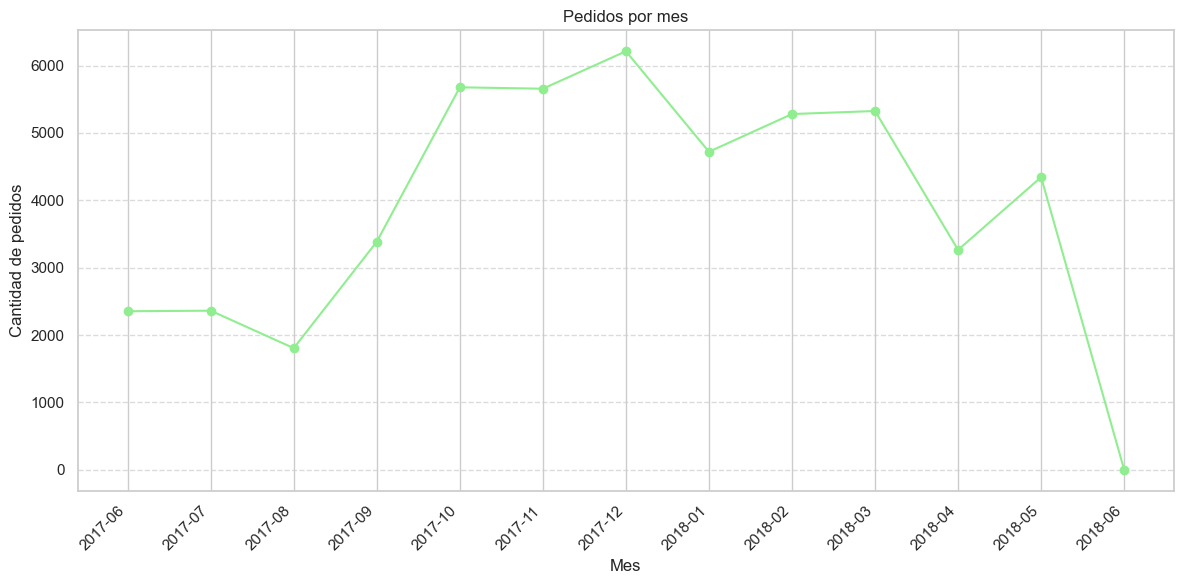

In [244]:
# Veremos cuántos pedidos se hicieron por mes 

orders_by_month = orders.groupby(['year_buy', 'month_buy'])['uid'].count().reset_index()
orders_by_month.rename(columns={'uid':'orders_count'}, inplace=True)

orders_by_month['period'] = orders_by_month['year_buy'].astype(str) + '-' + orders_by_month['month_buy'].astype(str).str.zfill(2)

plt.figure(figsize=(12,6))
plt.plot(orders_by_month['period'], orders_by_month['orders_count'], marker='o', color='lightgreen')

plt.xticks(rotation=45, ha='right')
plt.title('Pedidos por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de pedidos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Nuestros usuarios son más activos durante los meses fríos. 

In [245]:
# ¿Cuál es el tamaño promedio de compra?
buy_ave = orders['revenue'].mean()
print(f'El tamaño promedio de compra es de ${buy_ave:.2f}')

El tamaño promedio de compra es de $5.00


In [246]:
# ¿Cuánto dinero traen? (LTV)

ltv = orders.groupby('uid').revenue.sum()
ltv_ave = ltv.mean()
print(f'El life time value (LTV) es de ${ltv_ave:.2f}')

El life time value (LTV) es de $6.90


In [247]:
orders_by_uid = orders.groupby('uid').buy_ts.count().reset_index()
avg_orders_per_user = orders_by_uid.buy_ts.mean()
print(f'El promedio de órdenes por usuario es de {avg_orders_per_user:.2f} órdenes')

El promedio de órdenes por usuario es de 1.38 órdenes


In [248]:
# Queremos ver la distribución de número de órdenes por usuario
orders_by_uid.columns={'uid', 'order_count'}
orders_distribution = orders_by_uid.order_count.value_counts().sort_index()
orders_distribution

order_count
1      30220
2       4394
3       1086
4        373
5        147
       ...  
150        2
183        1
227        1
238        1
239        1
Name: count, Length: 62, dtype: int64

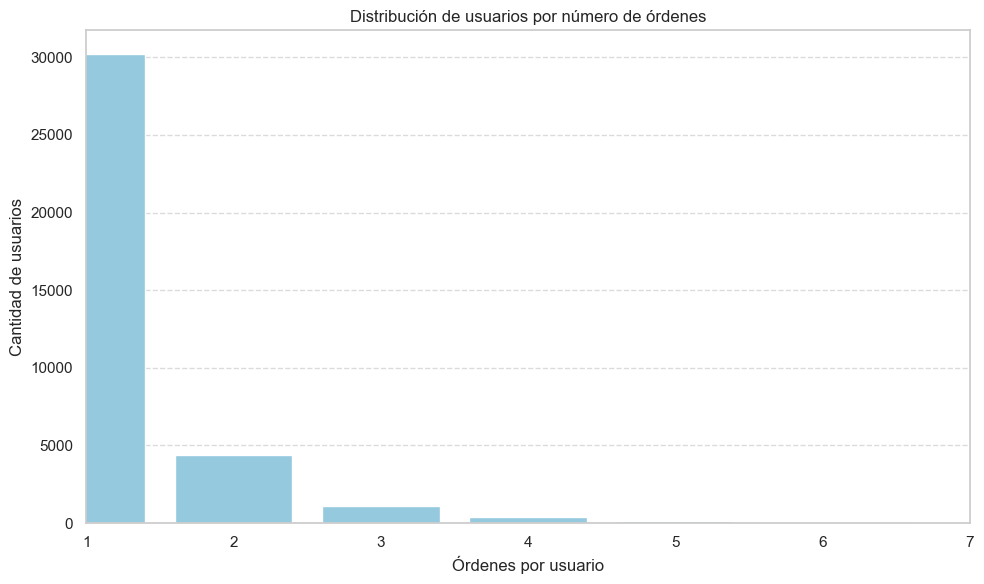

In [249]:

# Creamos gráfico

plt.figure(figsize=(10, 6))
sns.countplot(data=orders_by_uid, x='order_count', color='skyblue')
plt.xlim(0, 6)
plt.title('Distribución de usuarios por número de órdenes')
plt.xlabel('Órdenes por usuario')
plt.ylabel('Cantidad de usuarios')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Limitamos la gráfica para mostrar usuarios que hicieron de 1 - 6 órdenes

La mayoría de los usuarios hace la compra el mismo día en que se registra y no vuelve a comprar en el mismo año. Aunque se reportan usuarios que comprán más de 1 vez durante nuestro año de observación, hay uids que llegan a hacer hasta 239 compras. Todos estos usuarios creemos que son agencias turísticas. 

## Marketing:
 1. ¿Cuánto dinero se gastó?  (Total/por fuente de adquisición/a lo largo del tiempo) 
 2. ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?
 3. ¿Cuán rentables eran las inversiones? (romi)
Traza gráficos para mostrar cómo difieren estas métricas para varios dispositivos y fuentes de anuncios y cómo cambian con el tiempo. 

In [250]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [251]:
# Agregamos columnas de mes y año para poder agrupar por source_id y temporalidad

costs['month'] = costs['dt'].dt.month
costs['year'] = costs['dt'].dt.year
costs_by_source_by_month = costs.groupby(['source_id','year', 'month'])['costs'].sum().reset_index()
costs_by_source_by_month['date'] = pd.to_datetime(
    costs_by_source_by_month[['year', 'month']].assign(day=1)
)



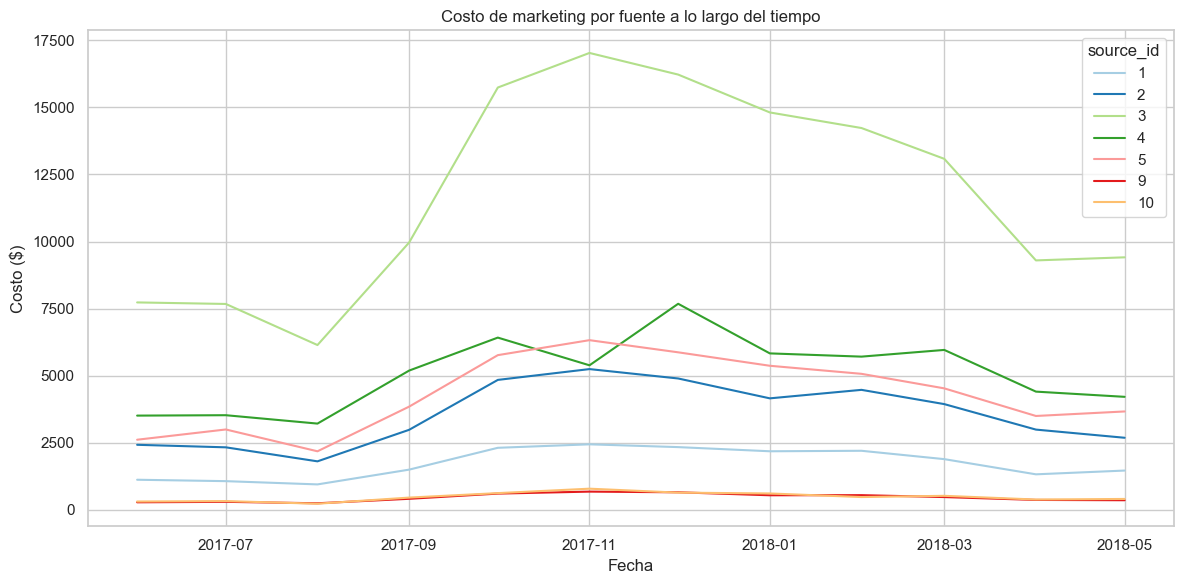

In [252]:
# Graficamos

plt.figure(figsize=(12, 6))
sns.lineplot(data = costs_by_source_by_month, x = 'date', y ='costs', hue = 'source_id', palette = 'Paired')
plt.title('Costo de marketing por fuente a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Costo ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [253]:
# Costo de adquisición por source_id (CAC)

costs_by_source = costs.groupby('source_id').costs.sum().reset_index()
users_by_source = orders.groupby('source_id').uid.nunique().reset_index()
users_by_source.columns=('source_id', 'unique_users')

cac = pd.merge(costs_by_source, users_by_source, on='source_id', how='left')
cac['cac'] = cac.costs / cac.unique_users
cac


,source_id,costs,unique_users,cac
0,1,20833.27,22431.0,0.928771
1,2,42806.04,9346.0,4.580146
2,3,141321.63,3268.0,43.244073
3,4,61073.60,1079.0,56.602039
4,5,51757.10,321.0,161.237072
5,9,5517.49,NaN,NaN
6,10,5822.49,NaN,NaN


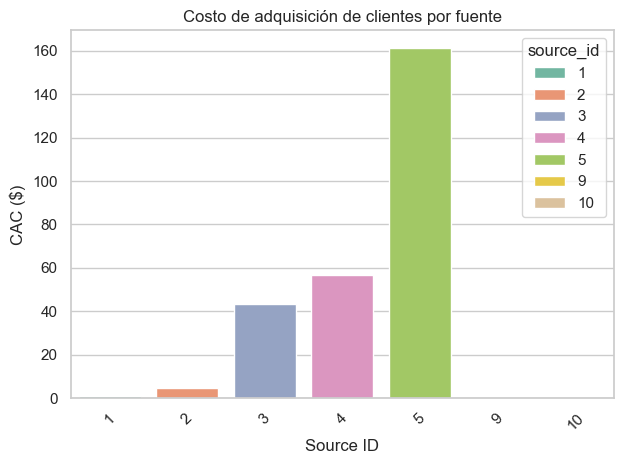

In [254]:
# Graficamos 

sns.barplot(data=cac, x='source_id', y='cac',hue = 'source_id', palette='Set2')
plt.title('Costo de adquisición de clientes por fuente')
plt.ylabel('CAC ($)')
plt.xlabel('Source ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [255]:
# ¿Cuán rentables eran las inversiones? (ROMI)
# Sacamos revenue por source_id
revenue_per_source = orders.groupby('source_id').revenue.sum().reset_index()
# hacemos merge con costs_by_source
romi_df = pd.merge(revenue_per_source, costs_by_source, on='source_id', how='left')
romi_df['romi'] = (romi_df.revenue - romi_df.costs) / romi_df.costs
print(romi_df.sort_values(by='romi', ascending = False))


   source_id   revenue      costs      romi
0          1  98724.56   20833.27  3.738793
1          2  66168.56   42806.04  0.545776
4          5  35459.94   51757.10 -0.314878
3          4  18180.00   61073.60 -0.702326
2          3  30065.66  141321.63 -0.787254
5          6   2676.61        NaN       NaN
6          7    781.87        NaN       NaN


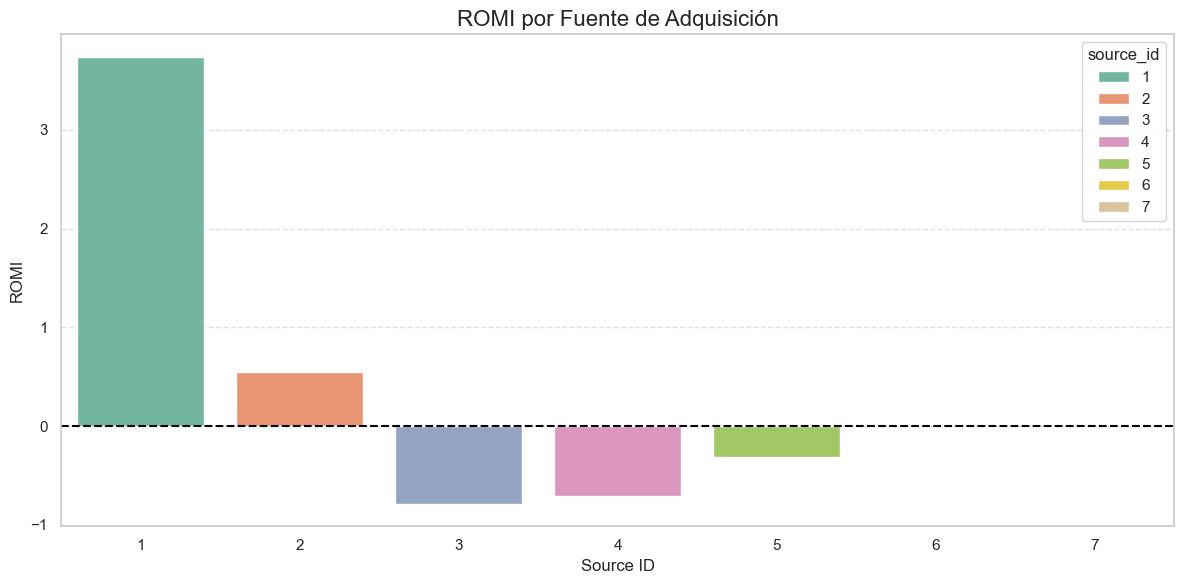

In [256]:
# graficamos

plt.figure(figsize=(12, 6))
sns.barplot(
    data=romi_df.sort_values(by='romi', ascending=False),
    x='source_id',
    y='romi',
    hue = 'source_id',
    palette='Set2' 
)
plt.title('ROMI por Fuente de Adquisición', fontsize=16)
plt.xlabel('Source ID')
plt.ylabel('ROMI')
plt.axhline(0, color='black', linestyle='--')  # Línea base en 0
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Traza gráficos para mostrar cómo difieren estas métricas para varios dispositivos y fuentes de anuncios y cómo cambian con el tiempo. 

## Paso 3. Escribe una conclusión: aconseja a los expertos de marketing cuánto dinero invertir y dónde

¿Qué fuentes/plataformas recomendarías?  Fundamenta tu selección: ¿en qué métricas te enfocaste?  ¿Por qué? ¿Qué conclusiones sacaste después de encontrar los valores métricos?



In [257]:
# Necesitamos una tabla que combine: source_id, devide, uid, revenue y costs

print(f'orders {orders.columns.to_list()}')
print()
print(f'visits {visits.columns.to_list()}')
print()
print(f'costs {costs.columns.to_list()}')

orders ['buy_ts', 'revenue', 'uid', 'first_buy_ts', 'registration_ts', 'days_to_purchase', 'convertion_delay', 'source_id', 'month_buy', 'year_buy']

visits ['device', 'end_ts', 'source_id', 'start_ts', 'uid', 'day', 'week', 'month', 'year', 'session_duration', 'session_duration_secs', 'time_since_last_visit', 'days_between_visits']

costs ['source_id', 'dt', 'costs', 'month', 'year']


In [258]:
# Filtramos por columnas clave
    
orders_clean = orders[['uid', 'revenue', 'source_id', 'month_buy', 'year_buy']]
orders_clean = orders_clean.rename(columns={'month_buy': 'month', 'year_buy': 'year'})
visits_clean = visits[['device', 'uid']]
costs_clean = costs[['source_id', 'costs', 'month', 'year']]

In [259]:
# Unimos las tablas

orders_visits = pd.merge(orders_clean, visits_clean, on='uid', how = 'left')
full_data = pd.merge(orders_visits, costs_clean, on=['source_id', 'month', 'year'], how='inner')
full_data.head()

,uid,revenue,source_id,month,year,device,costs
0,10329302124590727494,17.0,1,6,2017,desktop,75.20
1,10329302124590727494,17.0,1,6,2017,desktop,62.25
2,10329302124590727494,17.0,1,6,2017,desktop,36.53
3,10329302124590727494,17.0,1,6,2017,desktop,55.00
4,10329302124590727494,17.0,1,6,2017,desktop,57.08


In [260]:
summary = full_data.groupby(['source_id', 'device', 'year', 'month']).agg(
    revenue = ('revenue', 'sum'),
    costs = ('costs', 'sum'),
    users=('uid', 'nunique'),
    orders = ('uid', 'count')
).reset_index()

summary.sample(5)

,source_id,device,year,month,revenue,costs,users,orders
87,4,touch,2017,9,40635.30,1.230566e+06,42,7110
21,1,touch,2018,3,92402.70,1.310018e+06,462,20760
19,1,touch,2018,1,59003.54,1.217702e+06,408,17267
106,5,desktop,2018,4,8394285.77,1.039386e+08,62,860923
59,3,desktop,2018,5,1175524.03,5.805905e+07,264,191239


In [261]:
# Calculamos métricas

summary['romi'] = summary['revenue'] / summary['costs']                # Retorno sobre inversión en marketing
summary['cac'] = summary['costs'] / summary['users']                   # Costo de adquisición de cliente
summary['revenue_per_user'] = summary['revenue'] / summary['users']   # LTV aproximado
summary['orders_per_user'] = summary['orders'] / summary['users']     # Frecuencia de compra
summary.sample(5)

,source_id,device,year,month,revenue,costs,users,orders,romi,cac,revenue_per_user,orders_per_user
96,5,desktop,2017,6,2409495.00,39239183.88,27,449970,0.061405,1.453303e+06,89240.555556,16665.555556
15,1,touch,2017,9,46005.00,594795.96,297,11880,0.077346,2.002680e+03,154.898990,40.000000
113,5,touch,2017,11,396297.30,8798547.94,56,41730,0.045041,1.571169e+05,7076.737500,745.178571
109,5,touch,2017,7,92034.04,1127300.64,15,11656,0.081641,7.515338e+04,6135.602667,777.066667
9,1,desktop,2018,3,344704.80,5228714.58,1911,82860,0.065925,2.736114e+03,180.379278,43.359498


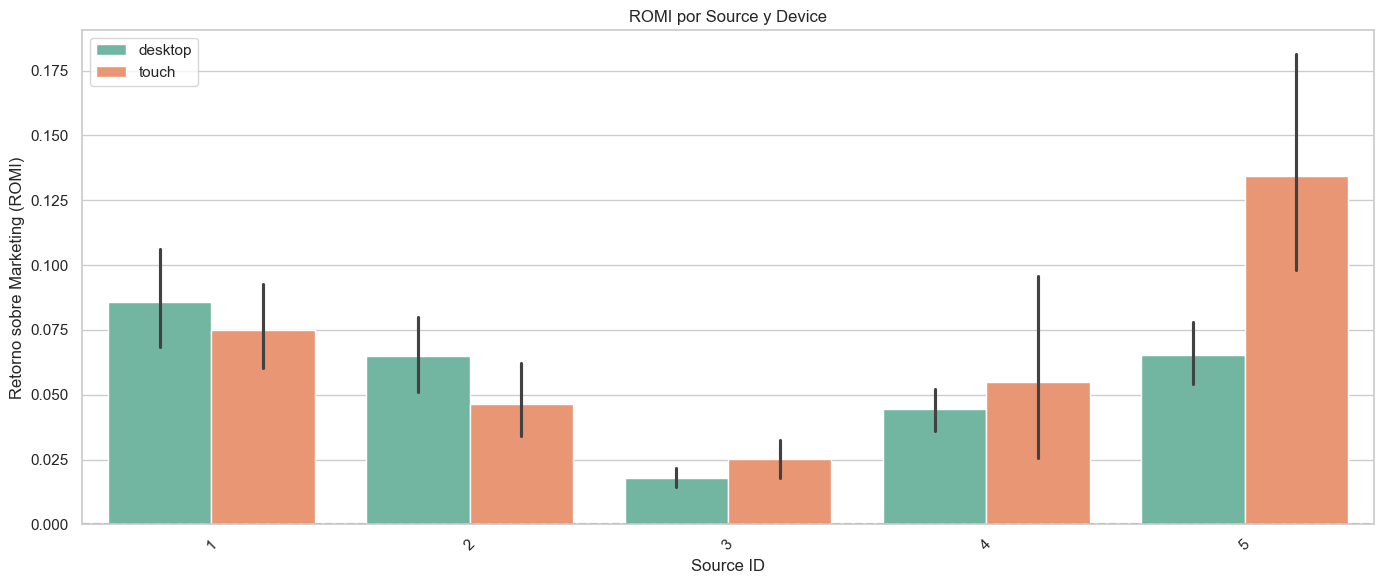

In [262]:
# ROMI por fuente y dispositivo

plt.figure(figsize=(14,6))
sns.barplot(data=summary, x='source_id', y='romi', hue='device', palette='Set2')
plt.axhline(0, color='gray', linestyle='--')
plt.title('ROMI por Source y Device')
plt.ylabel('Retorno sobre Marketing (ROMI)')
plt.xlabel('Source ID')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

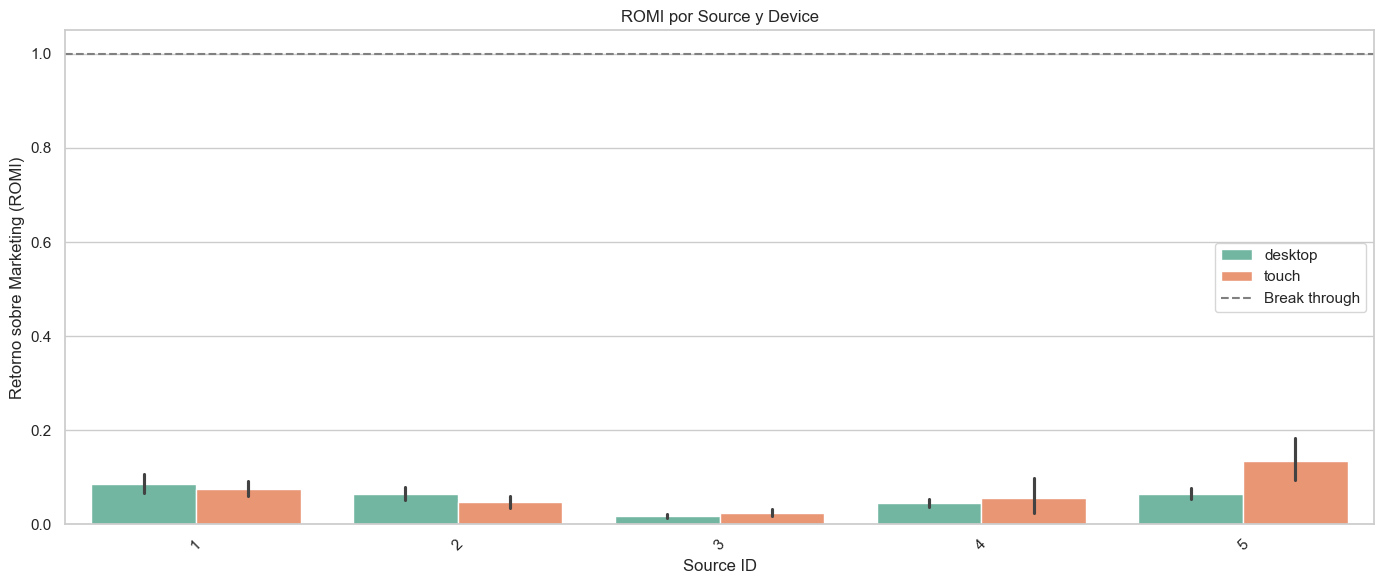

In [263]:
# ROMI por fuente y dispositivo

plt.figure(figsize=(14,6))
sns.barplot(data=summary, x='source_id', y='romi', hue='device', palette='Set2')
plt.axhline(1, color='gray', linestyle='--',label='Break through')
plt.title('ROMI por Source y Device')
plt.ylabel('Retorno sobre Marketing (ROMI)')
plt.xlabel('Source ID')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Habiendo graficado los ROMIs por Source y por Dispositivo podemos ver que el que sobresale es el Canal No. 5, sobre todo con los dispositivos touch. Es dificil hacer congeturas sobre las razones de este comportamiento ya que no sabemos nada de los canales. 

Sin embargo, haciendo un comparativo con el nivel de ROMI que deberían tener para ser algo rentable podemos ver que están muy por debajo del Punto de rentabilidad, ni siquiera llegando al 20% de lo necesario, esto nos indica que la compañía está perdiendo dinero, los costos superan a los ingresos.

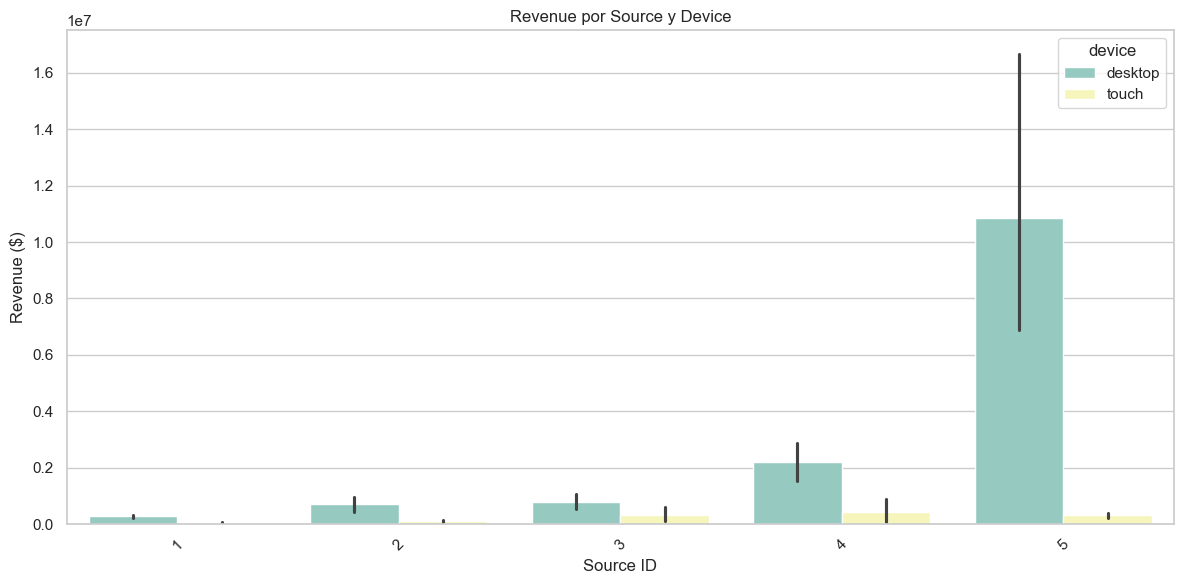

In [264]:
# Revenue por fuente y dispositivo
plt.figure(figsize=(12,6))
sns.barplot(data=summary, x='source_id', y='revenue', hue='device', palette='Set3')
plt.title('Revenue por Source y Device')
plt.ylabel('Revenue ($)')
plt.xlabel('Source ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El canal 5, con los dispositivos de escritorio, es grande en volumen, genera mucho dinero en comparación con las otras fuentes y dispositivos.
Se puede maximizar el retorno si invertimos más en ese canal vía dispositivos touch o podemos seguir creciendo los ingresos de ese canal optimizando los costos, apostando por Desktop y mejorando segmentación o ajustando pautas publicitarias.

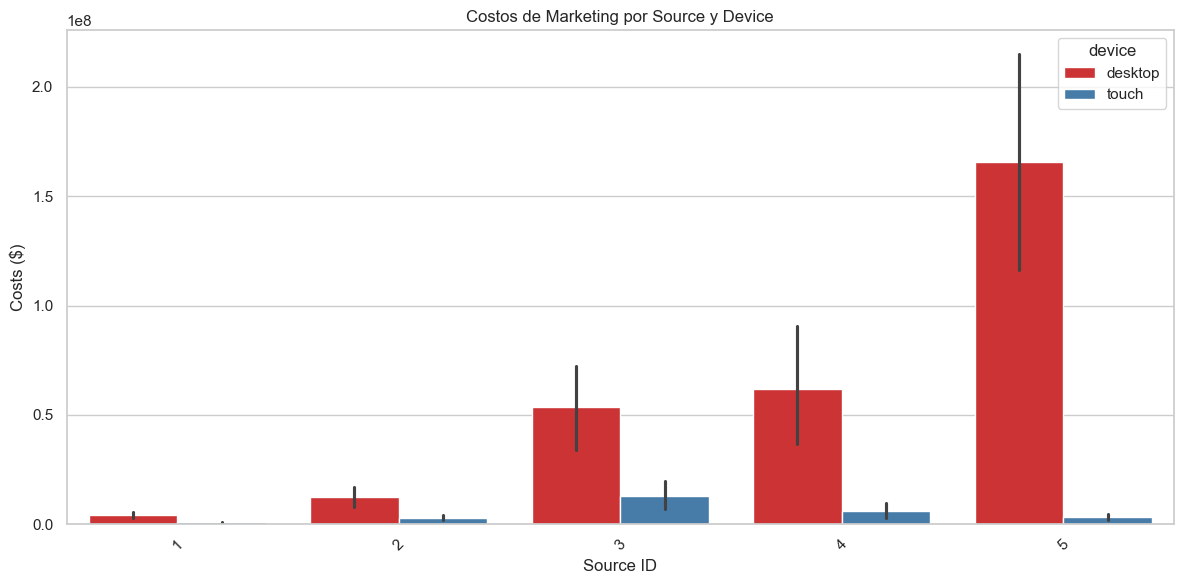

In [265]:
# Costs por fuente y dispositivo
plt.figure(figsize=(12,6))
sns.barplot(data=summary, x='source_id', y='costs', hue='device', palette='Set1')
plt.title('Costos de Marketing por Source y Device')
plt.ylabel('Costs ($)')
plt.xlabel('Source ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Y en efecto vemos que el canal 5 por Desktop costó más caro. Por eso no salió tan algo en el ROMI a pesar de que su revenue fue alto.

Otra cosa que notamos es que en todos nuestros canales, nos fue mucho más barato invertir en dispositivos móviles.

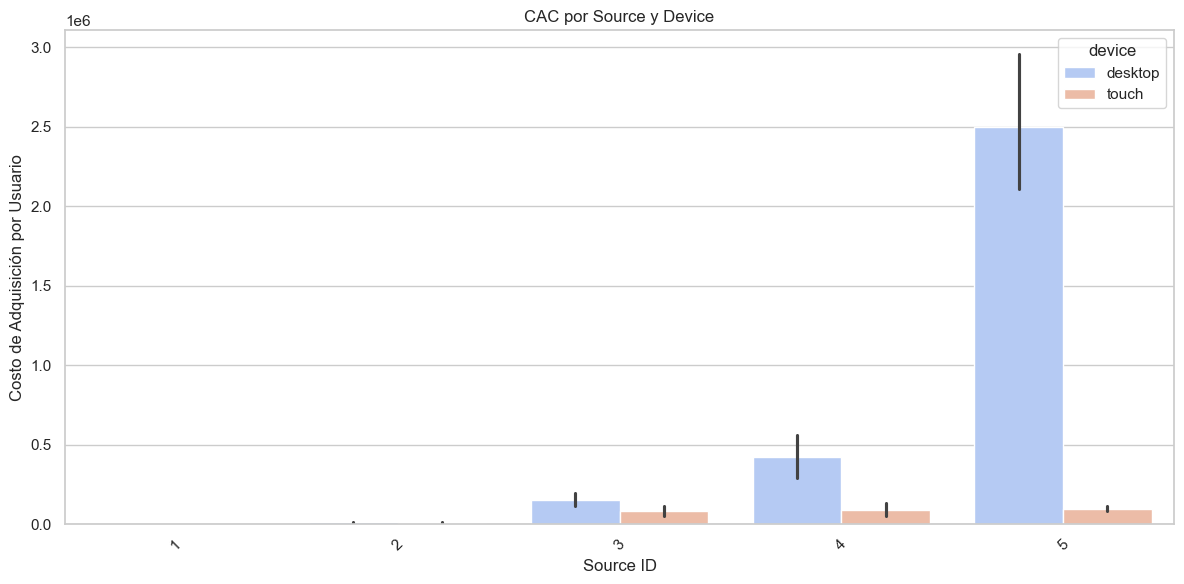

In [266]:
# CAC por fuente y dispositivo

plt.figure(figsize=(12,6))
sns.barplot(data=summary, x='source_id', y='cac', hue='device', palette='coolwarm')
plt.title('CAC por Source y Device')
plt.ylabel('Costo de Adquisición por Usuario')
plt.xlabel('Source ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Otra tabla similar en cuanto a su información. El Canal 5 en Desktop tiene un alto Costo de Adquisición. 

Si esto lo comparamos con el ROMI podemos pensar que estamos gastando demasiado para lo que se gana. Es una apuesta costosa que no vale la pena hacer.

In [267]:
summary['year_month'] = pd.to_datetime(summary[['year', 'month']].assign(day=1))


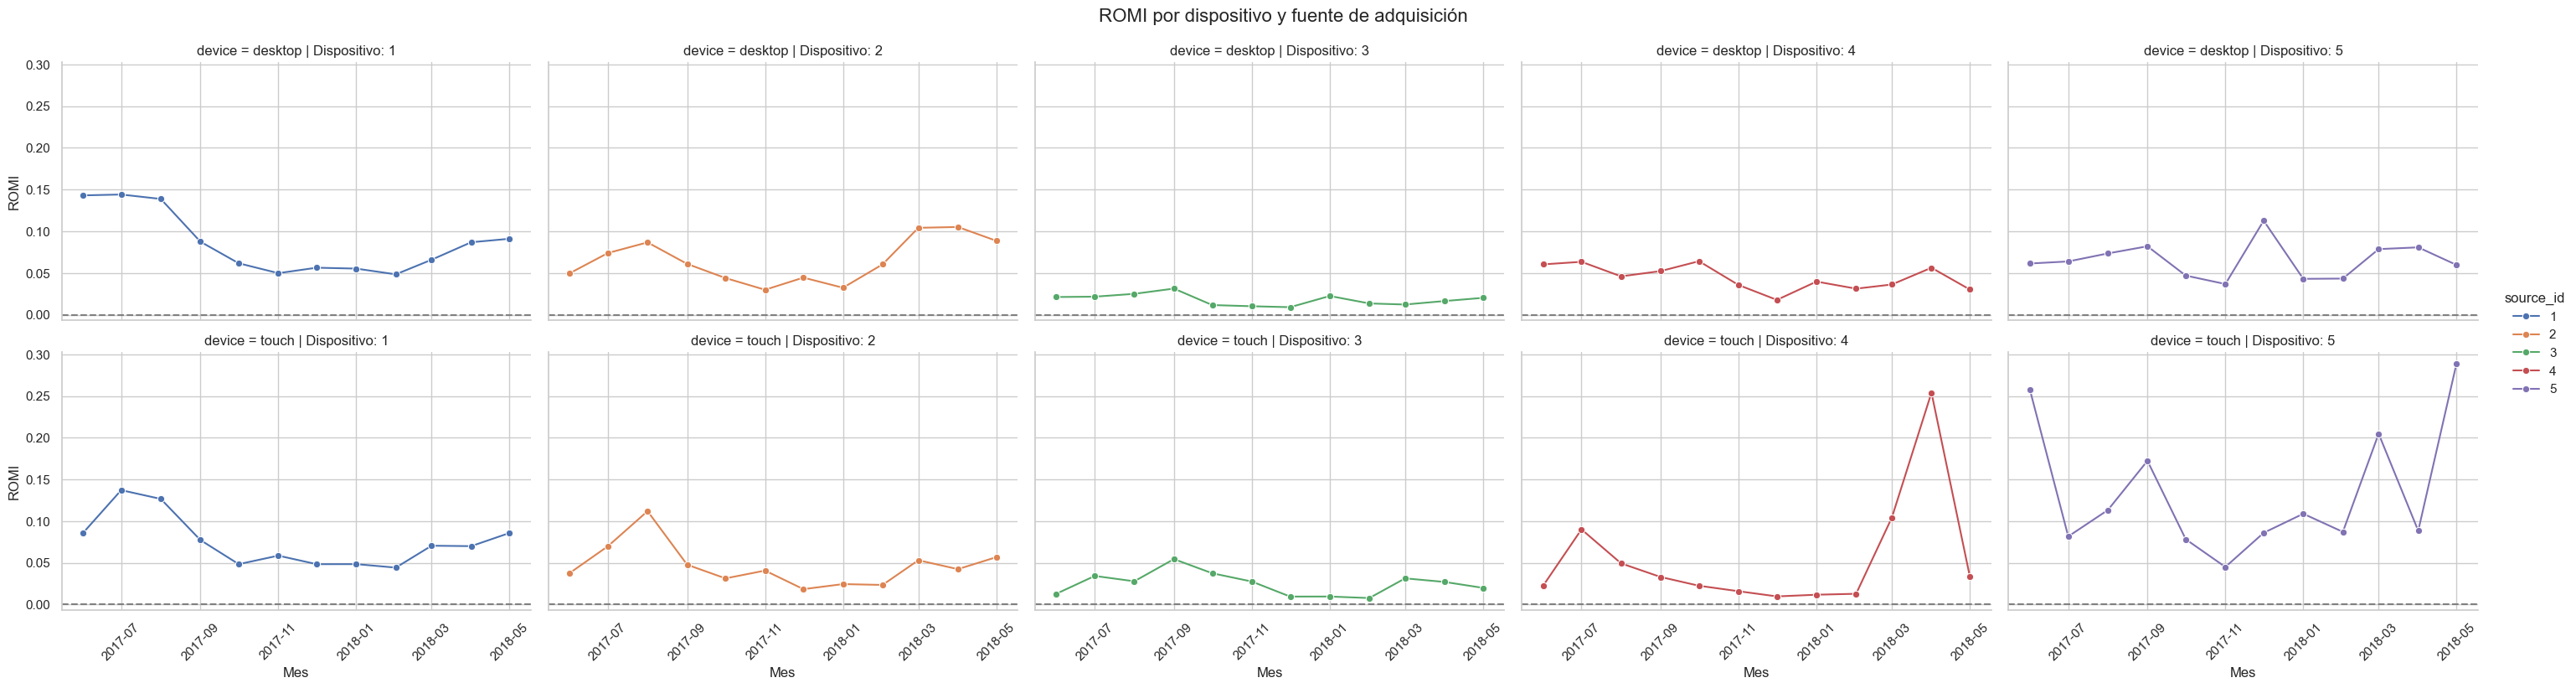

In [268]:
# ROMI por dispositivo y fuente de adquisición

g = sns.FacetGrid(summary, col='source_id', row='device', hue='source_id', height=4, aspect=1.5)
g.map(sns.lineplot, 'year_month', 'romi', marker='o')
g.add_legend(title='source_id')
g.set_titles(col_template="Dispositivo: {col_name}")
g.set_axis_labels("Mes", "ROMI")
for ax in g.axes.flat:
    ax.axhline(0, color='gray', linestyle='--')
    ax.tick_params(axis='x', rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("ROMI por dispositivo y fuente de adquisición", fontsize=16)
plt.show()


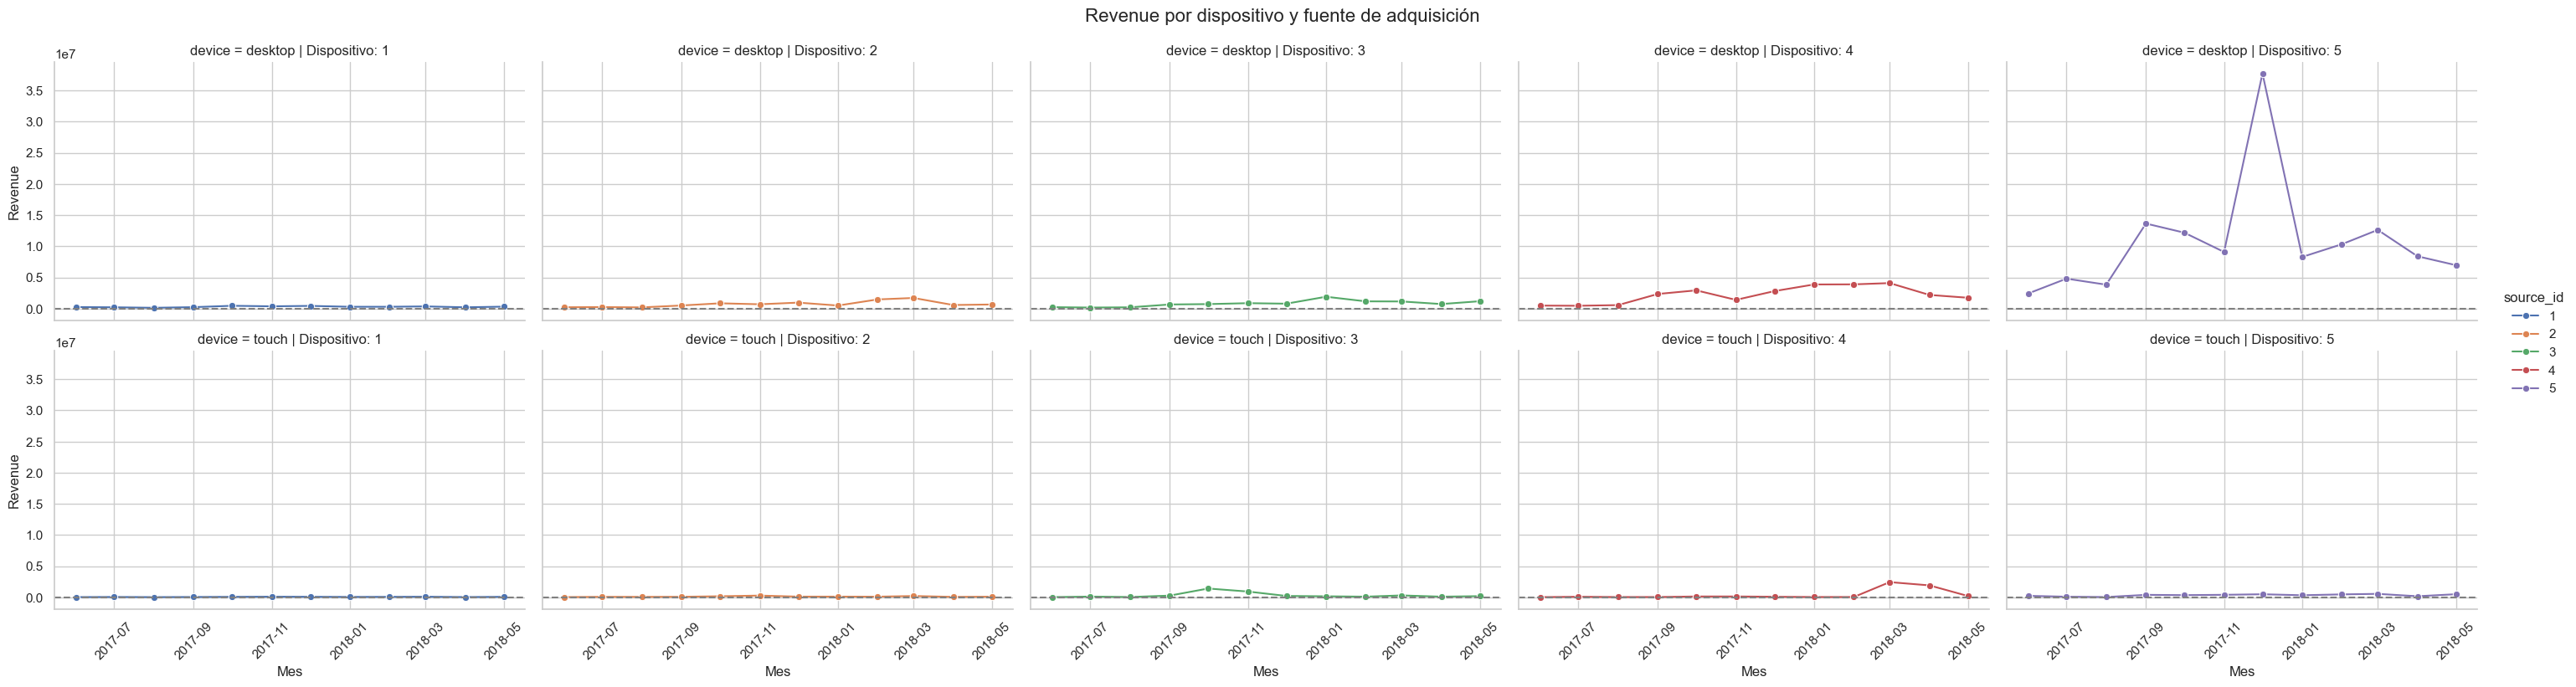

In [269]:
# Revenue por dispositivo y fuente de adquisición
g = sns.FacetGrid(summary, col='source_id', row='device', hue='source_id', height=4, aspect=1.5)
g.map(sns.lineplot, 'year_month', 'revenue', marker='o')
g.add_legend(title='source_id')
g.set_titles(col_template="Dispositivo: {col_name}")
g.set_axis_labels("Mes", "Revenue")
for ax in g.axes.flat:
    ax.axhline(0, color='gray', linestyle='--')
    ax.tick_params(axis='x', rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Revenue por dispositivo y fuente de adquisición", fontsize=16)
plt.show()

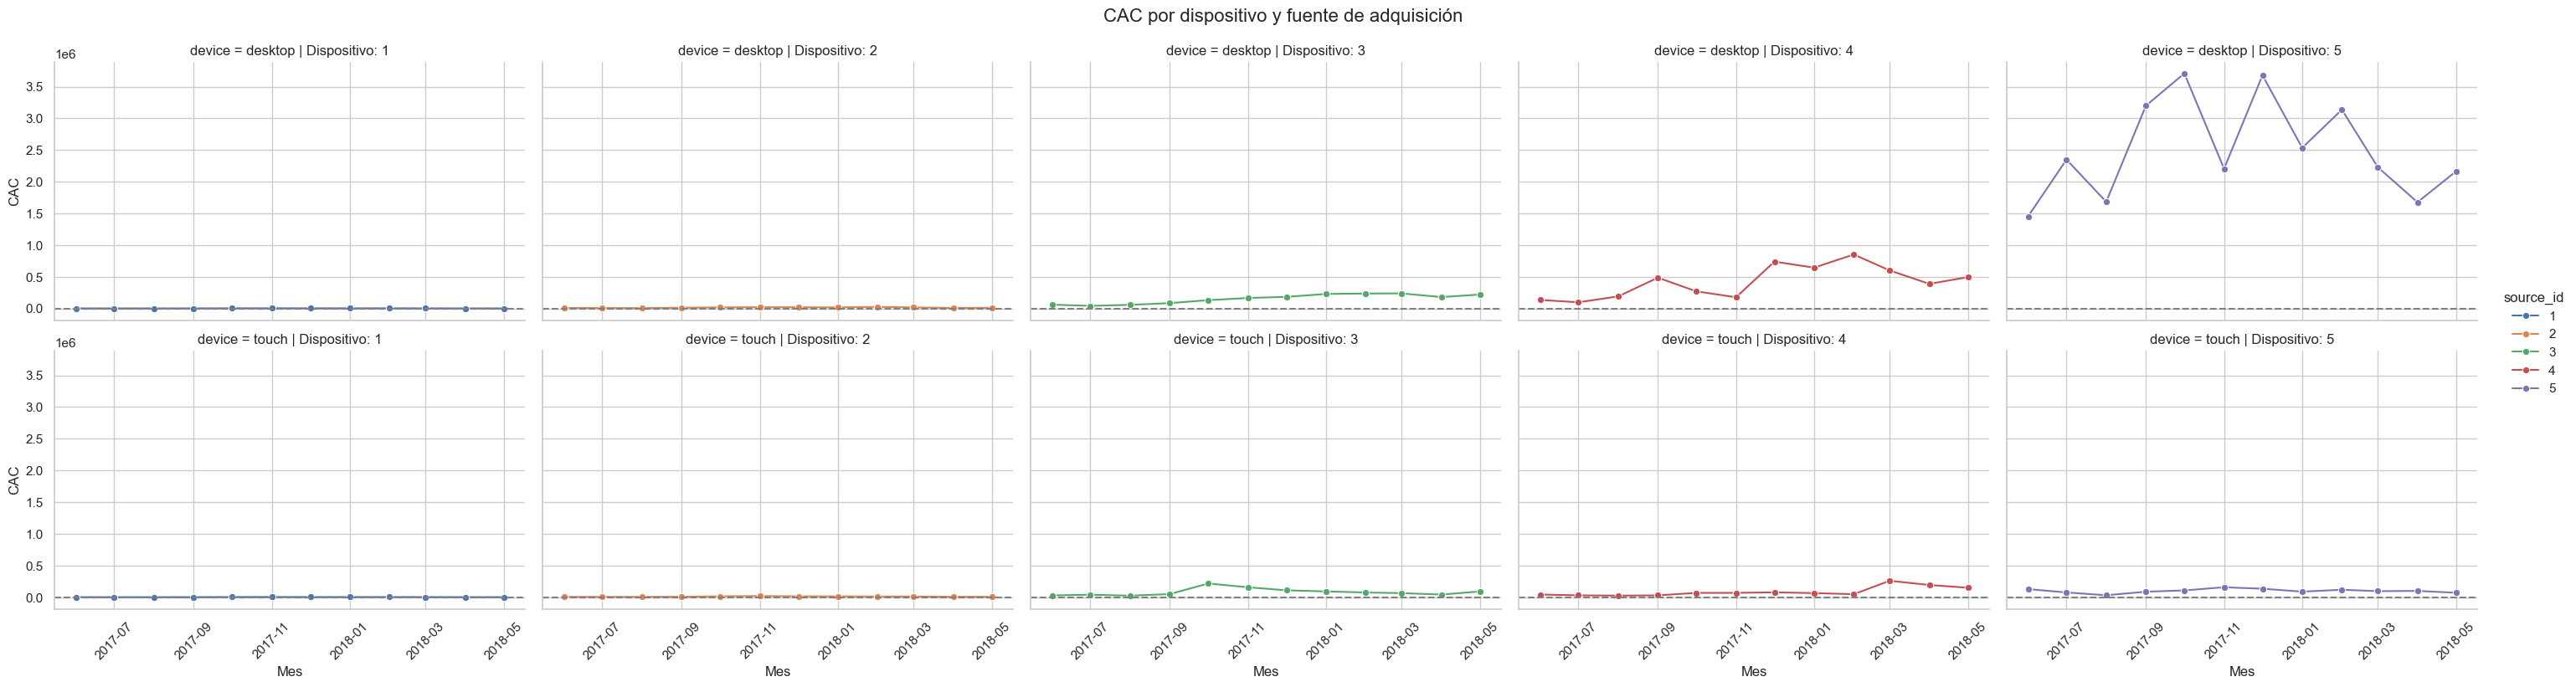

In [270]:
# CAC por dispositivo y fuente de adquisición
g = sns.FacetGrid(summary, col='source_id', row='device', hue='source_id', height=4, aspect=1.5)
g.map(sns.lineplot, 'year_month', 'cac', marker='o')
g.add_legend(title='source_id')
g.set_titles(col_template="Dispositivo: {col_name}")
g.set_axis_labels("Mes", "CAC")
for ax in g.axes.flat:
    ax.axhline(0, color='gray', linestyle='--')
    ax.tick_params(axis='x', rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("CAC por dispositivo y fuente de adquisición", fontsize=16)
plt.show()

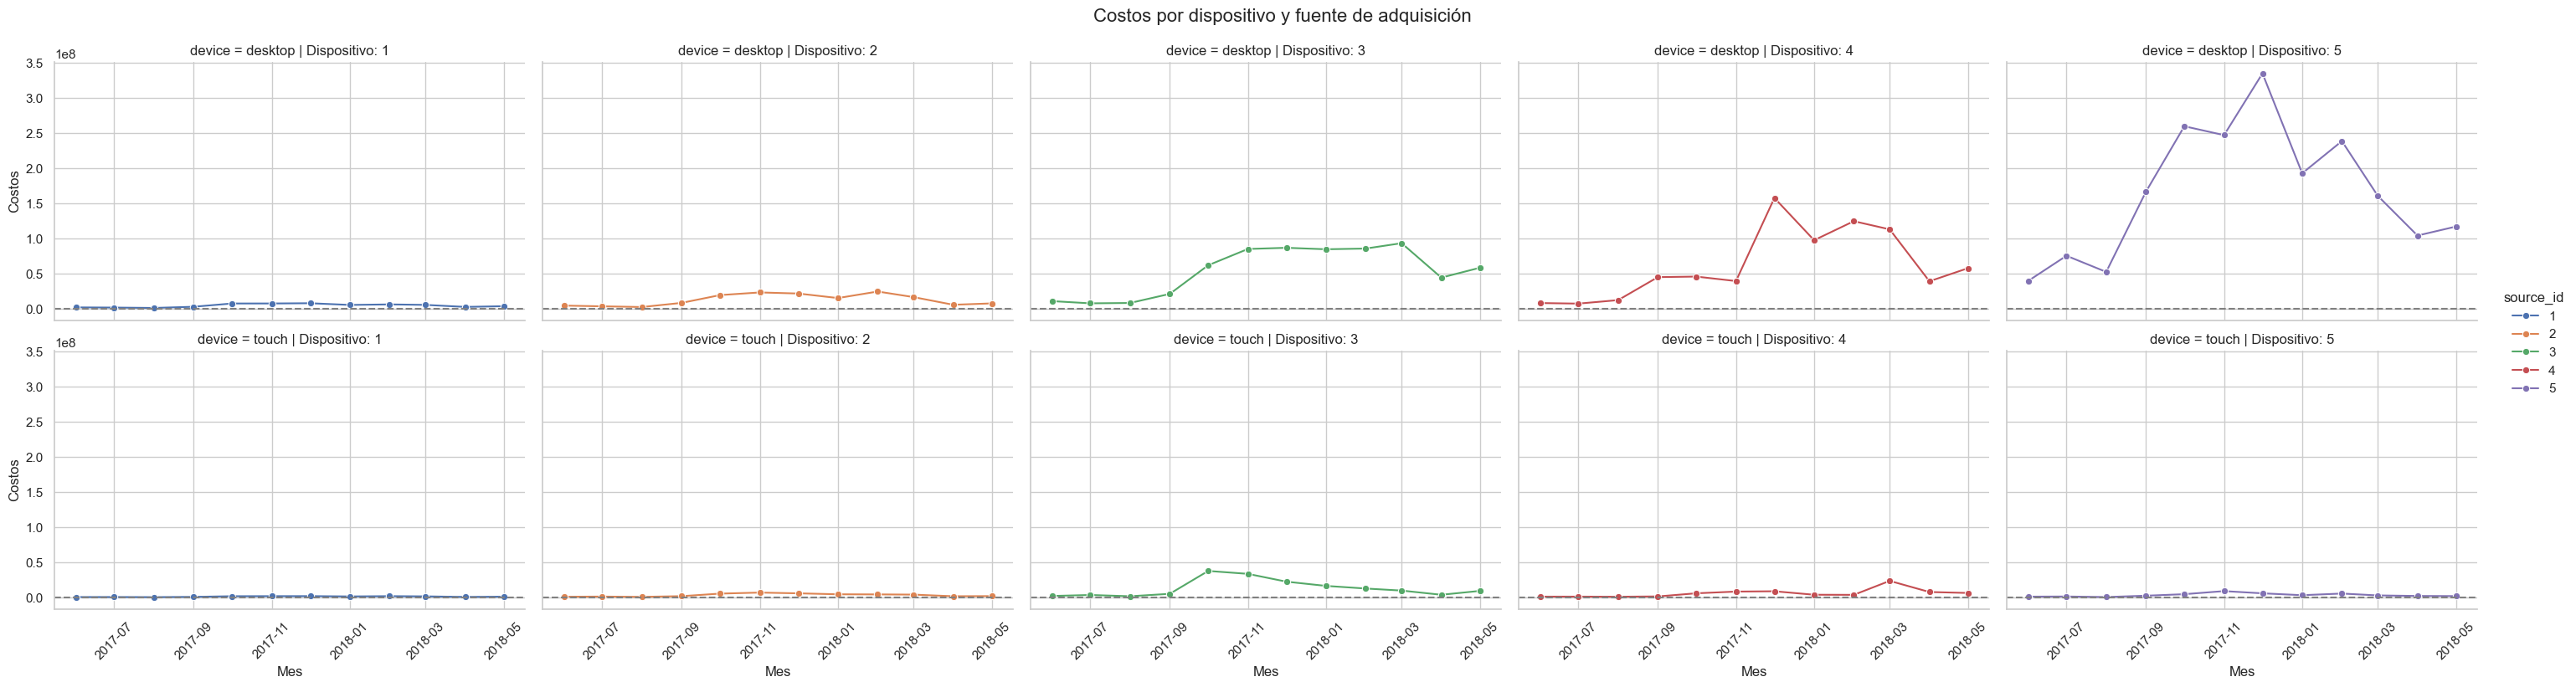

In [271]:
# Costos por dispositivo y fuente de adquisición
g = sns.FacetGrid(summary, col='source_id', row='device', hue='source_id', height=4, aspect=1.5)
g.map(sns.lineplot, 'year_month', 'costs', marker='o')
g.add_legend(title='source_id')
g.set_titles(col_template="Dispositivo: {col_name}")
g.set_axis_labels("Mes", "Costos")
for ax in g.axes.flat:
    ax.axhline(0, color='gray', linestyle='--')
    ax.tick_params(axis='x', rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Costos por dispositivo y fuente de adquisición", fontsize=16)
plt.show()

### Conclusiones
Al final concluimos que el Canal 5 en Desktop está dominando el flujo económico y las recomendaciones que tenemos son las siguientes: 
- Poner atención den el Canal 5 - Desktop ya que tenemos que averiguar por qué es tan dominante.
- Replicar características de ese Canal dominante (tipo de pauta, tipografías, gráficas, universos seleccionados).

### Dónde invertir?
💰 Si te interesa maximizar el retorno: podrías invertir más en el canal 5 vía dispositivos Touch.

📈 Si tu meta es crecer en ingresos absolutos, puede valer la pena seguir apostando por Desktop, pero optimizar el costo (mejor segmentación, ajustar pautas, etc.).

🧪 Idealmente: haz experimentos A/B para ver cómo puedes mejorar el ROMI en Desktop o aumentar el volumen en Touch.